<a href="https://colab.research.google.com/github/novtryrezki/Terbaru/blob/main/1CNN_bs_64_ep_20NonAug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import random
import shutil
import numpy as np
import tensorflow as tf
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split

In [2]:
# Melakukan mount pada Google Drive
drive.mount('/content/drive')

# Menentukan path file ZIP di Google Drive
zip_path = '/content/drive/MyDrive/images.zip'

# Membuat objek zip_ref
zip_ref = zipfile.ZipFile(zip_path, 'r')

# Mengekstrak file ZIP
extract_path ='/content/images'
zip_ref.extractall(extract_path)

# Tutup objek zip_ref setelah selesai
zip_ref.close()

Mounted at /content/drive


In [3]:
# Mendefinisikan path direktori dataset
dataset_dir = os.path.join(extract_path, 'images')
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
list_train = sorted(os.listdir(train_dir))
list_test = sorted(os.listdir(test_dir))

print("Daftar Angka pada Dataset Train yaitu : ", list_train)
print("Daftar Angka pada Dataset Test yaitu : ", list_test)

Daftar Angka pada Dataset Train yaitu :  ['angka 0', 'angka 1', 'angka 2', 'angka 3', 'angka 4', 'angka 5', 'angka 6', 'angka 7', 'angka 8', 'angka 9']
Daftar Angka pada Dataset Test yaitu :  ['angka 0', 'angka 1', 'angka 2', 'angka 3', 'angka 4', 'angka 5', 'angka 6', 'angka 7', 'angka 8', 'angka 9']


In [4]:
def count_images(directory):
    return sum(1 for file in os.listdir(directory) if file.endswith(('.jpg', '.jpeg', '.png', '.gif')))

# Menghitung jumlah gambar di data train
train_image_count = sum(count_images(os.path.join(train_dir, angka)) for angka in list_train)

# Menghitung jumlah gambar di data test
test_image_count = sum(count_images(os.path.join(test_dir, angka)) for angka in list_test)

print(f"Jumlah gambar di Dataset Train: {train_image_count}")
print(f"Jumlah gambar di Dataset Test: {test_image_count}")

Jumlah gambar di Dataset Train: 1763
Jumlah gambar di Dataset Test: 445


# Preprocessing

In [5]:
import cv2

def resize_images(directory, target_resolution):
    for angka in os.listdir(directory):
        angka_dir = os.path.join(directory, angka)
        for file_name in os.listdir(angka_dir):
            file_path = os.path.join(angka_dir, file_name)
            img = cv2.imread(file_path)
            resized_img = cv2.resize(img, (target_resolution[0], target_resolution[1]))
            cv2.imwrite(file_path, resized_img)

target_resolution = (52, 78)
resize_images(train_dir, target_resolution)
resize_images(test_dir, target_resolution)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Membuat generator data dengan augmentasi
image_size = (52, 78)
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale = 1./255,
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 1763 images belonging to 10 classes.
Found 445 images belonging to 10 classes.


# Membuat Model CNN

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
import math

img_size = 52*78*1

# Perhitungan jumlah neuron pada lapisan tersembunyi
hidden_neurons = 201

model1c = Sequential()
model1c.add(Conv2D(32, (3, 3), activation='relu', input_shape=(52, 78, 1)))
model1c.add(AveragePooling2D((2, 2)))
model1c.add(Conv2D(64, (3, 3), activation='relu'))
model1c.add(AveragePooling2D((2, 2)))
model1c.add(Flatten())
model1c.add(Dense(hidden_neurons, activation='relu'))
model1c.add(Dense(10, activation='softmax'))

model1c.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Mendapatkan bobot dari model
weights = []
for layer in model1c.layers:
    weights.append(layer.get_weights())

print("Bobot dari model:")
for i, layer_weights in enumerate(weights):
    print("Layer", i+1)
    for j, w in enumerate(layer_weights):
        print("  Bobot {}: {}".format(j+1, w.shape))

Bobot dari model:
Layer 1
  Bobot 1: (3, 3, 1, 32)
  Bobot 2: (32,)
Layer 2
Layer 3
  Bobot 1: (3, 3, 32, 64)
  Bobot 2: (64,)
Layer 4
Layer 5
Layer 6
  Bobot 1: (12672, 201)
  Bobot 2: (201,)
Layer 7
  Bobot 1: (201, 10)
  Bobot 2: (10,)


In [17]:
# Menampilkan matriks bobot dan vektor bias dari setiap layer
for i, layer in enumerate(model1c.layers):
    weights = layer.get_weights()
    if weights:
        print("Layer", i+1)
        for j, w in enumerate(weights):
            if j == 0:
                print("  Bobot:")
            else:
                print("  Bias:")
            print("    Ukuran:", w.shape)
            print("    Nilai:")
            print(w)

Layer 1
  Bobot:
    Ukuran: (3, 3, 1, 32)
    Nilai:
[[[[ 0.00669584 -0.02615062  0.0502854   0.0717902  -0.07962377
     0.10435513  0.03881562  0.05844794  0.04831101 -0.07915328
    -0.00743085  0.02731618 -0.10003001 -0.05704273  0.02001908
    -0.00360161  0.00422809 -0.10452937  0.07533878 -0.11289084
    -0.03249789 -0.09400698 -0.0098988   0.06949647  0.1044354
     0.08109915 -0.06492249 -0.06194233 -0.00549622 -0.069607
     0.04445934 -0.11993049]]

  [[-0.02434304  0.03487286 -0.08755907 -0.01721172  0.01077285
     0.06226088  0.10782878  0.12248324 -0.01337968  0.10158402
    -0.00590135 -0.07527724  0.13056277  0.13825206 -0.10118669
     0.05417007  0.11025052  0.13174559  0.06920534 -0.01131807
    -0.06455041 -0.1105559   0.08914974  0.089755   -0.05585437
    -0.06182935  0.09793307 -0.00518164 -0.05220203  0.0547365
    -0.06277559 -0.05565149]]

  [[-0.09357556  0.09243488 -0.02115932  0.08813627  0.0888148
    -0.09583263 -0.10321464 -0.04948084  0.03722003 -0.02

In [18]:
model1c.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 50, 76, 32)        320       
                                                                 
 average_pooling2d_2 (Avera  (None, 25, 38, 32)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_3 (Conv2D)           (None, 23, 36, 64)        18496     
                                                                 
 average_pooling2d_3 (Avera  (None, 11, 18, 64)        0         
 gePooling2D)                                                    
                                                                 
 flatten_1 (Flatten)         (None, 12672)             0         
                                                                 
 dense_2 (Dense)             (None, 201)              

In [19]:
history = model1c.fit(train_generator, epochs=20, verbose = 1)

Epoch 1/20
28/28 [==============================] - 8s 277ms/step - loss: 2.1043 - accuracy: 0.3341
Epoch 2/20
28/28 [==============================] - 6s 214ms/step - loss: 1.9115 - accuracy: 0.4141
Epoch 3/20
28/28 [==============================] - 7s 241ms/step - loss: 1.7561 - accuracy: 0.4555
Epoch 4/20
28/28 [==============================] - 7s 237ms/step - loss: 1.5619 - accuracy: 0.5014
Epoch 5/20
28/28 [==============================] - 6s 216ms/step - loss: 1.4516 - accuracy: 0.5258
Epoch 6/20
28/28 [==============================] - 8s 274ms/step - loss: 1.2983 - accuracy: 0.5854
Epoch 7/20
28/28 [==============================] - 6s 212ms/step - loss: 1.2253 - accuracy: 0.6177
Epoch 8/20
28/28 [==============================] - 8s 278ms/step - loss: 1.1143 - accuracy: 0.6551
Epoch 9/20
28/28 [==============================] - 6s 213ms/step - loss: 0.9946 - accuracy: 0.6869
Epoch 10/20
28/28 [==============================] - 8s 274ms/step - loss: 1.0134 - accuracy: 0.6756

#Matriks Konfusi

7/7 [==============================] - 1s 78ms/step


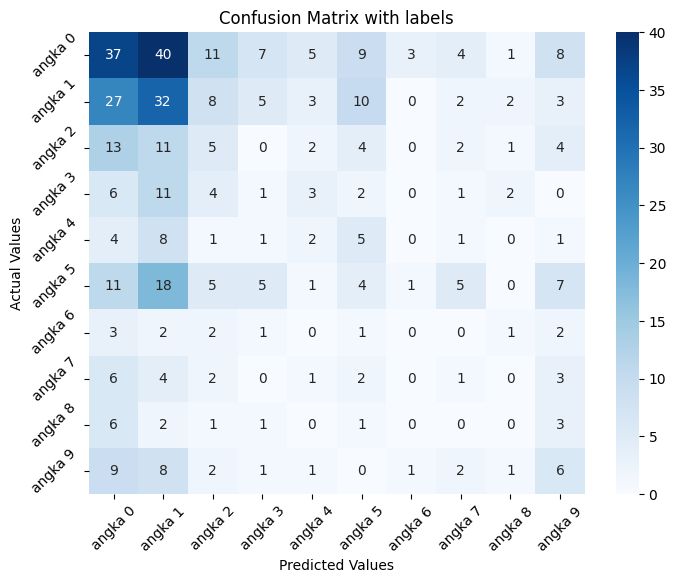

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Fungsi untuk mendapatkan prediksi model dan label sebenarnya
def get_predictions_and_labels(model, data_generator):
    predictions = model.predict(data_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = data_generator.classes
    class_labels = list(data_generator.class_indices.keys())
    return predicted_classes, true_classes, class_labels

# Mendapatkan prediksi dan label sebenarnya untuk data uji
y_pred, y_true, class_labels = get_predictions_and_labels(model1c, test_generator)

# Membuat matriks konfusi
cf_matrix = confusion_matrix(y_true, y_pred)

# Membuat visualisasi matriks konfusi
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues', ax=ax)

# Menetapkan label dan judul
ax.set_title('Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

# Menetapkan label pada sumbu x dan y sesuai dengan jenis kelas
ax.xaxis.set_ticklabels(class_labels, rotation=45)
ax.yaxis.set_ticklabels(class_labels, rotation=45)

# Menampilkan visualisasi Matriks Konfusi
plt.show()

In [27]:
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.19775280898876405
